# Spark Recommender Pair Exercise

## Loading  and Cleaning Data

We have two options here

1. Load data into a Pandas dataframe, convert to a Spark dataframe
    * Careful! This only works because our dataset is small. Usually when we use Spark our datasets are too large to fit in memory.
2. Load data into a Spark RDD, convert to a Spark dataframe

### Pandas

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql.types import *
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# Build our Spark Session and Context
spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext
spark, sc;

# Read the ratings data into a Pandas DataFrame
ratings_pd_df = pd.read_csv('data/training.csv')

# Convert to a Spark DataFrame, dropping `timestamp` column will happend before the train
ratings_df = spark.createDataFrame(ratings_pd_df) #.drop('timestamp', axis=1))

In [2]:
ratings_df    = ratings_df.orderBy('timestamp')
ratings_pd_df = ratings_df.toPandas()

n_rows = ratings_pd_df.shape[0] # int(n_rows*.8)


train = ratings_pd_df.head(int(n_rows*.95))
test  = ratings_pd_df.tail(int(n_rows*.05))

sp_train = spark.createDataFrame(train.drop('timestamp', axis=1))
sp_test  = spark.createDataFrame( test.drop('timestamp', axis=1))

In [3]:
req_pd = pd.read_csv('data/requests.csv')
sp_req = spark.createDataFrame(req_pd)

In [6]:
als_model = ALS(userCol='user',
                itemCol='movie',
                ratingCol='rating',
                nonnegative=True,
                regParam=0.05,
                maxIter=20,
                rank=12,
                coldStartStrategy = "nan"
               )

recommender = als_model.fit(sp_train)

In [20]:
# Make predictions for the whole test set
prediction_sp = recommender.transform(sp_req)

## Evaluation

Time to evaluate our model. We'll calculate the RMSE of our predicted ratings and also look at a violin plot of true ratings (x-axis) vs the predicted ratings (y-axis).

In [21]:
predictions_pd = prediction_sp.toPandas()

In [22]:
movie_means = predictions_pd.groupby('movie', sort=False).mean()['prediction']
movie_means.head()

movie
148    2.632260
463    2.237283
471    3.649536
496    3.825910
833    2.369985
Name: prediction, dtype: float32

In [23]:
pred_nulls = predictions_pd[predictions_pd['prediction'].isna()]

indexed_means = pred_nulls.apply(lambda x: movie_means.loc[x['movie']], axis=1)

predictions_pd['prediction'].loc[pred_nulls.index] = indexed_means

/Users/nreyna/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [24]:
predictions_pd.head()

,user,movie,prediction
0,53,148,2.632260
1,4169,148,3.168971
2,5333,148,2.542454
3,4387,148,2.185355
4,840,148,2.632260


In [25]:
# Fill any missing values with the mean rating
# There are multiple things you could fill with, this is just one example
predictions_pd = predictions_pd.fillna(4.67842)

In [48]:
predictions_pd['movie'].value_counts();

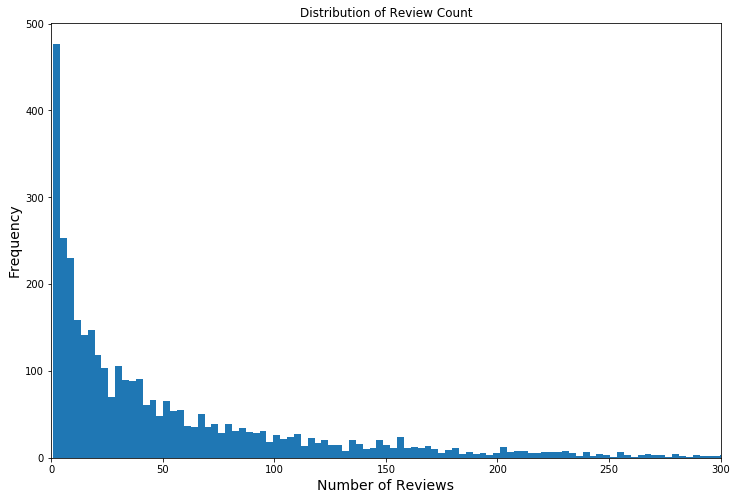

In [47]:
f, ax = plt.subplots(figsize=(12,8))
plt.hist(predictions_pd['movie'].value_counts(), bins=200)
plt.title("Distribution of Review Count")
plt.ylabel('Frequency', fontsize=14);
plt.xlabel('Number of Reviews', fontsize=14);
plt.xlim(0,300);


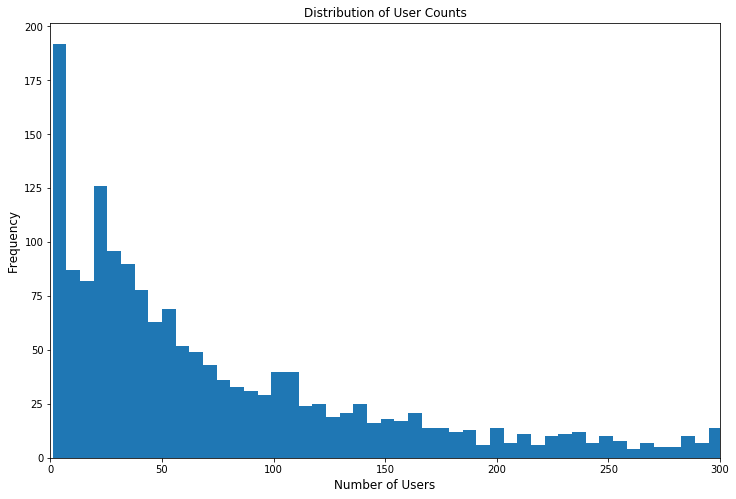

In [46]:
f, ax = plt.subplots(figsize=(12,8))
plt.hist(predictions_pd['user'].value_counts(), bins=200)
plt.title("Distribution of User Counts")
plt.ylabel('Frequency', fontsize=12);
plt.xlabel('Number of Users', fontsize=12);
plt.xlim(0,300);

In [ ]:
predictions_pd['sq_err'] = (predictions_pd['rating'] - predictions_pd['prediction'])**2

In [ ]:
np.sqrt(predictions_pd['sq_err'].sum()/ len(predictions_pd))

### plotting sparsity

In [49]:
ratings_pd_df.shape

(800000, 4)

In [51]:
ratings_pd_df.head()

,user,movie,rating,timestamp
0,6040,858,4,956703932
1,6040,593,5,956703954
2,6040,2384,4,956703954
3,6040,1961,4,956703977
4,6040,2019,5,956703977


In [57]:
x_u = np.array(ratings_pd_df.user)
y_m = np.array(ratings_pd_df.movie)

In [59]:
len(x_u)

800000

In [60]:
len(y_m)

800000

In [71]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import numpy as np

x, y, z, a = np.loadtxt('data/training.csv', delimiter=",")
# df = pd.read_csv('data/training.csv')

N = int(len(z)**.5)
z = z.reshape(N, N)
plt.imshow(z+10, extent=(np.amin(x), np.amax(x), np.amin(y), np.amax(y)),
        cmap=cm.hot, norm=LogNorm())
plt.colorbar()
plt.show()

### SVD

In [1]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix

values = (sp_train.
    rdd.
    map(lambda r: (r.id, r.image)).
    sortByKey(). 
    flatMap(lambda id, image: image).
    collect())


ncol = len(sp_train.rdd.map(lambda r: r.image).first())
nrow = sp_train.count()

dm = DenseMatrix(nrow, ncol, values)

In [ ]:
# Compute the top 5 singular values and corresponding singular vectors.
svd = mat.computeSVD(5, computeU=True)
U = svd.U       # The U factor is a RowMatrix.
s = svd.s       # The singular values are stored in a local dense vector.
V = svd.V  

In [15]:
type(prediction_sp)

pyspark.sql.dataframe.DataFrame

In [ ]:
mask = predictions_pd['rating'] > 3
mask.sum()

predictions_pd['sq_err_45'] = (predictions_pd['rating'][mask] - predictions_pd['prediction'][mask])**2

In [ ]:
# Calculate RMSE
np.sqrt(sum(predictions_pd['sq_err_45']) / mask.sum())

In [ ]:
predictions_pd.describe().T

In [ ]:
predictions_pd.fillna(0, inplace=True)

In [ ]:
predictions_pd.to_csv('data/pred3.csv', sep=',', index=False)

In [ ]:
# predictions_pd['squared_error'] = (predictions_pd['rating'][mask] - predictions_pd['prediction'][mask])**2